# Waveguide design

In this notebook, we will explore how to design waveguides for single-mode operation at different wavelengths and using different materials.

For this, we will rely on the band diagram of our waveguide of interest in the direction of propagation, and our main tool to obtain that band structure will be the mode solver [MPB](https://mpb.readthedocs.io/en/latest/).

In [ ]:
from functools import partial

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

from phodex.modes.mpb import get_bands, plot_bands, find_k, neff_from_k

mp.verbosity.mpb = 0

## Setup

First we set some general parameters that we will use throughout the notebook, mainly the resolution of our simulations and the range and number of $k$-vectors that we want to sample. Since we are only interested in modes that are propagating along the waveguide, we only sample $k_x$.

In [2]:
resolution = 20  # this will be the no. of pixels per smallest wavelength

num_k = 50
k_min = 0.1
k_max = 2.5

k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])
ks = np.array([k.x for k in k_points])

## Modes of a silicon buried oxide waveguide

Before we start designing waveguides, we will take a look at a known structure and discuss the reasoning behind our approach.

A standard single-mode silicon buried oxide waveguide as a height of 220nm and a width of 450nm for operation at a wavelength of 1550nm.
Let's set that up and have a look at the band diagram of this waveguide.

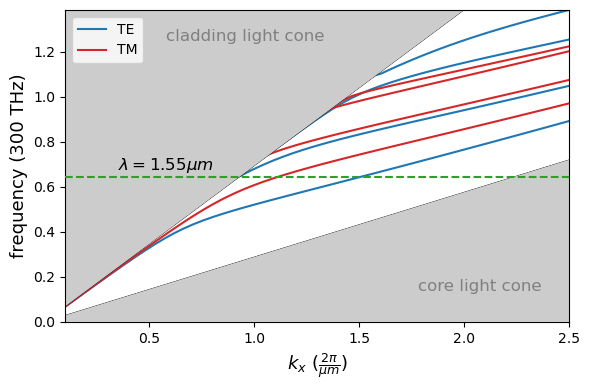

Effective index of fundamental mode at 1.55µm:
 TE: 2.346
 TM: 1.733


In [3]:
lcen = 1.55
wvg_width = 0.45
wvg_height = 0.22
n_core = 3.4777  # Si @ 1550nm
n_clad = 1.4440
num_bands = 4

geometry_lattice = mp.Lattice(size=mp.Vector3(0, 6 * wvg_width, 6 * wvg_height))

geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, wvg_width, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = partial(
    get_bands,
    k_points,
    int(resolution * n_core / lcen),
    num_bands,
    geometry,
    geometry_lattice,
    mp.Medium(index=n_clad),
)
results = {p: ms(p) for p in ["te", "tm"]}

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_core,
    n_clad,
    ax=ax,
)
plt.show()

print(
    f"Effective index of fundamental mode at {lcen}µm:\n"
    f' TE: {neff_from_k(lcen, ks, results["te"]["freqs"][:, 0]):.3f}\n'
    f' TM: {neff_from_k(lcen, ks, results["tm"]["freqs"][:, 0]):.3f}'
)

As you can see, only the lowest order TE and TM modes intersect with our operating wavelength below the light line of the cladding (the gray shaded area).
This means that there is only a single propagating TE and TM mode for this specific waveguide, and the higher-order modes are not propagating at this wavelength.
The effective index of those propagating modes is simply the operating wavelength times the value of $k_x$ at the intersection.

We can also observe that the second-order TE mode "enters" the cladding light line _just_ before intersecting with our operational wavelength (coming from the right).
This means that our waveguide is just barely single-mode - if it were slightly wider or taller for example, the second-order TE mode would intersect with the operating wavelength _before_ it enters the cladding light line and our waveguide would support two propagating modes, i.e. it wouldn't be single-mode anymore.

Next, we will increase the width of the waveguide to 900nm and see how that affects the band diagram.

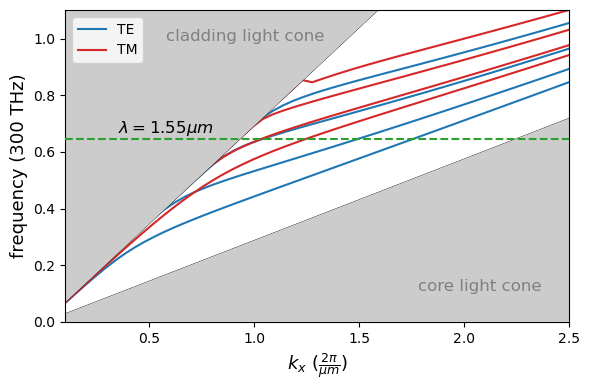

In [4]:
lcen = 1.55
wvg_width = 0.9
wvg_height = 0.22
n_core = 3.4777  # Si @ 1550nm
n_clad = 1.4440
num_bands = 4

geometry_lattice = mp.Lattice(size=mp.Vector3(0, 6 * wvg_width, 6 * wvg_height))

geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, wvg_width, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = partial(
    get_bands,
    k_points,
    int(resolution * n_core / lcen),
    num_bands,
    geometry,
    geometry_lattice,
    mp.Medium(index=n_clad),
)
results = {p: ms(p) for p in ["te", "tm"]}

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_core,
    n_clad,
    ax=ax,
)
plt.show()

Now this is definitely not single-mode anymore - we get three TE intersections and two TM intersections at our operating wavelength.

## Waveguides "on-demand"

Now, let's try to design some single-mode waveguides for TE operation!

The key insight that we need here is simply that the second-order mode may not have an intersection with our operating wavelength below the light line of the cladding.

We will define an objective function that does the following:
 1. Calculate TE modes up to the second band (actually we will be calculating for one order higher than that, but that's because MPB sometimes gives unreliable results for the highest order band that it calculates, so we want to avoid that).
 2. Get the dispersion relation for the second-order band and find the $k_x$ at which it intersects with our target wavelength.
 3. Subtract the operational wavelength from the value of the light line of the cladding at this $k_x$. If the value is negative, then we are above the light line and the mode is not propagating, and conversely, we have a propagating second-order mode if the value is positive.

This objective function has a zero-crossing at the point where the waveguide starts to support more than one propagating mode at the operational wavelength.
We can either simply do a parameter sweep now for different waveguide widths and identify the point of the sign change, or we can do this a bit more efficiently by applying a root-finding algorithm to the problem.

In [5]:
def objective(w, h, lcen, n_core, n_clad, resolution, k_points, k_vals, lattice, dw=1e-4):
    fcen = 1 / lcen
    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, w + dw, wvg_height),
            material=mp.Medium(index=n_core),
            center=mp.Vector3(),
        ),
    ]
    freqs = get_bands(
        k_points,
        resolution,
        3,
        geometry,
        lattice,
        mp.Medium(index=n_clad),
        "te",
    )["freqs"]
    kx = find_k(lcen, k_vals, freqs[:, 1])  # crossing of second order mode
    light_line = UnivariateSpline(k_vals, k_vals / n_clad, s=0)
    return light_line(kx) - fcen

### Optimization of a silicon box waveguide for 1310nm

First, we will apply our method to identify the maximum width that a silicon waveguide with a height of 220nm can have to be single-mode at an operational wavelength of 1310nm.
The only thing we need to take care of is the range of widths that we want to check.
We already know that a width of 450nm is the upper bound for single-mode operation at 1550nm, so we will pick this as an upper bound for our search.
We don't really know what the lower bound is, so we'll just pick a width of 250nm as a pretty safe value.

In [6]:
lcen = 1.31
wvg_height = 0.22
n_core = 3.4975  # Si @ 1310nm
n_clad = 1.4440
geometry_lattice = mp.Lattice(size=mp.Vector3(0, 6 * wvg_width, 6 * wvg_height))

fit = root_scalar(
    objective,
    args=(
        wvg_height,
        lcen,
        n_core,
        n_clad,
        int(resolution * n_core / lcen),
        k_points,
        ks,
        geometry_lattice,
    ),
    method="brentq",
    bracket=[0.25, 0.45],
    xtol=1e-3,
)

print(fit)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.3289024751888936


Seems like we have converged to a solution in just a few simulations!
Time to have a look at the band diagram of the waveguide we just made.

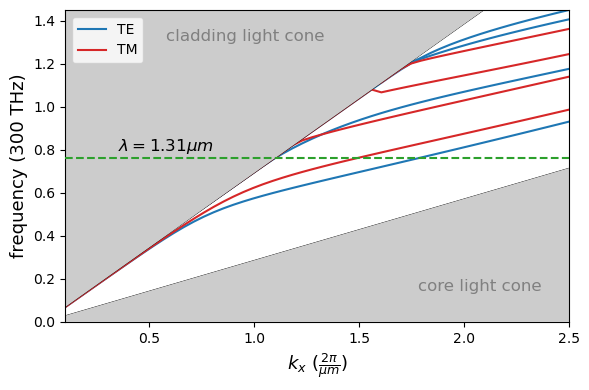

Effective index of fundamental mode at 1.31µm:
 TE: 2.346
 TM: 1.962


In [7]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, fit.root, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = partial(
    get_bands,
    k_points,
    int(resolution * n_core / lcen),
    4,
    geometry,
    geometry_lattice,
    mp.Medium(index=n_clad),
)
results = {p: ms(p) for p in ["te", "tm"]}

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_core,
    n_clad,
    ax=ax,
)
plt.show()

print(
    f"Effective index of fundamental mode at {lcen}µm:\n"
    f' TE: {neff_from_k(lcen, ks, results["te"]["freqs"][:, 0]):.3f}\n'
    f' TM: {neff_from_k(lcen, ks, results["tm"]["freqs"][:, 0]):.3f}'
)

Looks great! The second-order TE mode enters the light line of the cladding _just_ before hitting our operational wavelength, exactly what we wanted!

### Optimization of a silicon nitride waveguide for 1550nm

Next, we will design a silicon nitride waveguide for 1550nm operation.
The procedure is exactly the same as before, but this time we know neither the upper nor the lower bound for our search.
As silicon nitride has a much lower refractive index than just silicon, the waveguide is going to be much wider than the pure silicon one.
An upper bound of 1.5 microns for the waveguide width will put us on the safe side, as that is definitely more than what is needed for single-mode operation.
As a lower bound we will choose 0.5 microns, as that is almost the width of a pure silicon waveguide, which is definitely less than what we will be needing here.

In [8]:
lcen = 1.55
wvg_height = 0.4
n_core = 1.9963  # Si3N4 @ 1550nm
n_clad = 1.4440
geometry_lattice = mp.Lattice(size=mp.Vector3(0, 6 * wvg_width, 6 * wvg_height))

fit = root_scalar(
    objective,
    args=(
        wvg_height,
        lcen,
        n_core,
        n_clad,
        int(resolution * n_core / lcen),
        k_points,
        ks,
        geometry_lattice,
    ),
    method="brentq",
    bracket=[0.5, 1.5],
    xtol=1e-3,
)

print(fit)

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 1.0614160675983093


And once again, let's check the full band diagram.

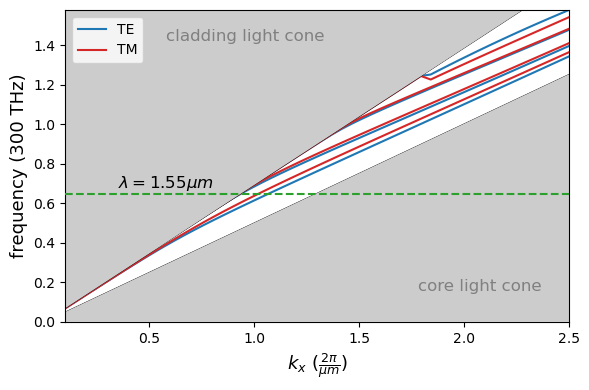

Effective index of fundamental mode at 1.55µm:
 TE: 1.646
 TM: 1.573


In [9]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, fit.root, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = partial(
    get_bands,
    k_points,
    int(resolution * n_core / lcen),
    4,
    geometry,
    geometry_lattice,
    mp.Medium(index=n_clad),
)
results = {p: ms(p) for p in ["te", "tm"]}

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_core,
    n_clad,
    ax=ax,
)
plt.show()

print(
    f"Effective index of fundamental mode at {lcen}µm:\n"
    f' TE: {neff_from_k(lcen, ks, results["te"]["freqs"][:, 0]):.3f}\n'
    f' TM: {neff_from_k(lcen, ks, results["tm"]["freqs"][:, 0]):.3f}'
)

And once again, our method works just fine!